Load Tensorflow

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import random
import os
from glob import glob
from PIL import Image
import pathlib

import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import utils
from tensorflow.keras import Model

batch_size = 32

TensorFlow version: 2.6.0


Load helper functions and preview the data

In [2]:
from src.datareader import get_metadata, get_summary_data
from src.find_images_without_metadata import find_images_without_metadata
from src.labelenums import Label

In [3]:
metadata: pd.DataFrame = get_metadata()
summarydata: pd.DataFrame = get_summary_data()
print(summarydata)

      Label Label_2_Virus_category Label_1_Virus_category  Image_Count
0    Normal                                                       1576
1  Pnemonia         Stress-Smoking                   ARDS            2
2  Pnemonia                  Virus                                1493
3  Pnemonia                  Virus               COVID-19           58
4  Pnemonia                  Virus                   SARS            4
5  Pnemonia               bacteria                                2772
6  Pnemonia               bacteria          Streptococcus            5


In [4]:
metadata.head()

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,,
1,IM-0127-0001.jpeg,Normal,TRAIN,,
2,IM-0125-0001.jpeg,Normal,TRAIN,,
3,IM-0122-0001.jpeg,Normal,TRAIN,,
4,IM-0119-0001.jpeg,Normal,TRAIN,,


Let's verify that all the images are in the metadata, else we could run into issues if not careful. If you run into any problems, stop here and fix them.

In [6]:
for dataset in ['TRAIN', 'TEST']:
    extra_files = find_images_without_metadata(dataset)
    if len(extra_files) == 0:
        continue
    for file_name in extra_files:
        fullname = os.path.join(os.getcwd(), 'dataset', dataset, file_name)
        if os.path.isfile(fullname):
            print('Removing file: ' + fullname)
            os.remove(fullname)
    find_images_without_metadata(dataset)


There are 15 more files than listed in the metadata
These files are missing in the metadata:
1-s2.0-S0929664620300449-gr3_lrg-a.jpg
1-s2.0-S0929664620300449-gr3_lrg-b.jpg
1-s2.0-S0929664620300449-gr3_lrg-c.jpg
1-s2.0-S0929664620300449-gr3_lrg-d.jpg
191F3B3A-2879-4EF3-BE56-EE0D2B5AAEE3.jpeg
21DDEBFD-7F16-4E3E-8F90-CB1B8EE82828.jpeg
396A81A5-982C-44E9-A57E-9B1DC34E2C08.jpeg
3ED3C0E1-4FE0-4238-8112-DDFF9E20B471.jpeg
5083A6B7-8983-472E-A427-570A3E03DDEE.jpeg
66298CBF-6F10-42D5-A688-741F6AC84A76.jpeg
6A7D4110-2BFC-4D9A-A2D6-E9226D91D25A.jpeg
925446AE-B3C7-4C93-941B-AC4D2FE1F455.jpeg
kjr-21-e24-g001-l-b.jpg
kjr-21-e24-g002-l-c.jpg
kjr-21-e24-g003-l-b.jpg
Removing file: D:\Users\Matthew\Documents\GitHub\coronahack_chest_x-ray\dataset\TRAIN\1-s2.0-S0929664620300449-gr3_lrg-a.jpg
Removing file: D:\Users\Matthew\Documents\GitHub\coronahack_chest_x-ray\dataset\TRAIN\1-s2.0-S0929664620300449-gr3_lrg-b.jpg
Removing file: D:\Users\Matthew\Documents\GitHub\coronahack_chest_x-ray\dataset\TRAIN\1-s2.0-

Separate between training and testing

In [7]:
train_sample = metadata.loc[metadata['Dataset_type'] == 'TRAIN']
test_sample = metadata.loc[metadata['Dataset_type'] == 'TEST']
train_path = os.path.join(os.getcwd(), 'dataset', 'TRAIN')
test_path = os.path.join(os.getcwd(), 'dataset', 'TEST')

Preview some images in the training data

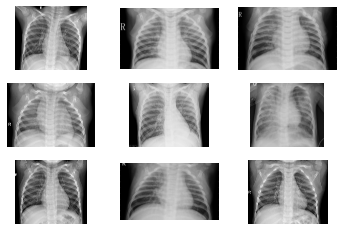

In [8]:
fig, axes = plt.subplots(3, 3, squeeze=False, )
random_image_indices = random.sample(range(len(train_sample)), 9)
image_names = list(train_sample.iloc[random_image_indices]['X_ray_image_name'])
for n in range(9):
    this_axis = axes[n//3, n%3]
    filename = os.path.join(train_path, image_names[n])
    img = mpimg.imread(filename)
    imgplot = this_axis.imshow(img, cmap='gray')
    this_axis.axis('off')


As you can see, the images are not uniform in shape, so we still have some preprocessing to do

In [9]:
image_size_counter = {}
for basename in train_sample['X_ray_image_name']:
    filename = os.path.join(train_path, basename)
    size = Image.open(filename).size
    if size in image_size_counter.keys():
        image_size_counter[(size, size[0] * size[1])] += 1
    else:
        image_size_counter[(size, size[0] * size[1])] = 1
smallest_picture_index = np.argmin([x[1] for x in list(image_size_counter.keys())])
largest_picture_index = np.argmax([x[1] for x in list(image_size_counter.keys())])
print('Smallest image size: ', list(image_size_counter.keys())[smallest_picture_index][0])
print('Large image size: ', list(image_size_counter.keys())[largest_picture_index][0])

Smallest image size:  (384, 127)
Large image size:  (4248, 3480)


Since the images differ widely in size, we must resort to resizing them and normalizing them.

In [10]:
new_size = (256, 256)
AUTOTUNE = tf.data.AUTOTUNE
class_names = np.unique(np.array(train_sample['Label']))
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
labeler = Label()


def get_train_label(file_path):
    # Convert the path to a list of path components
    filename = os.path.basename(file_path)
    copy = train_sample.copy()
    names_ds = list(copy['X_ray_image_name'].copy())
    labels_ds = list(copy['Label'].copy())
    label_str = labels_ds[names_ds.index(filename)]
    label_int = labeler[label_str]
    return label_int


def get_test_label(file_path):
    # Convert the path to a list of path components
    filename = os.path.basename(file_path)
    copy = test_sample.copy()
    names_ds = list(copy['X_ray_image_name'].copy())
    labels_ds = list(copy['Label'].copy())
    label_str = labels_ds[names_ds.index(filename)]
    label_int = labeler[label_str]
    return label_int


def process_path(file_path, label):
    img1 = tf.io.read_file(file_path)
    img2 = tf.io.decode_png(img1, channels=1)
    img3 = tf.image.resize(img2, new_size, method='lanczos3', antialias=True)
    img4 = normalization_layer(img3)
    return img4, label


In [11]:
train_image_paths = [os.path.join(train_path, x) for x in os.listdir(train_path)]
test_image_paths = [os.path.join(test_path, x) for x in os.listdir(test_path)]
train_labels = np.array([get_train_label(x) for x in train_image_paths], dtype=int)
test_labels = np.array([get_test_label(x) for x in test_image_paths], dtype=int)

In [12]:
train_image_paths_tensors = tf.convert_to_tensor(train_image_paths, dtype=tf.string)
train_labels_tensors = tf.convert_to_tensor(train_labels)
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths_tensors, train_labels_tensors))
train_dataset = train_dataset.map(process_path, num_parallel_calls=AUTOTUNE)

test_image_paths_tensors = tf.convert_to_tensor(test_image_paths, dtype=tf.string)
test_labels_tensors = tf.convert_to_tensor(test_labels)
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_paths_tensors, test_labels_tensors))
test_dataset = test_dataset.map(process_path, num_parallel_calls=AUTOTUNE)


print(tf.data.experimental.cardinality(train_dataset).numpy())
print(tf.data.experimental.cardinality(test_dataset).numpy())

5286
624


In [13]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_dataset = configure_for_performance(train_dataset)
test_dataset = configure_for_performance(test_dataset)

In [14]:
metrics = [
#     tf.keras.metrics.TruePositives(name='tp'),
#     tf.keras.metrics.FalsePositives(name='fp'),
#     tf.keras.metrics.TrueNegatives(name='tn'),
#     tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.MeanSquaredError(),
    tf.keras.metrics.CategoricalAccuracy(),
    tf.keras.metrics.BinaryCrossentropy(),
#     tf.keras.metrics.Recall(name='recall'),
#     tf.keras.metrics.AUC(name='auc', curve='ROC')
]

In [19]:
filters = 10
kernel_size = (3, 3)
activation = 'relu'
num_classes = len(class_names)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters, 
                           kernel_size=kernel_size, 
                           activation=activation,
                           strides=1,
                           padding='valid',
                           input_shape=(new_size[0], new_size[1], 1)),
    tf.keras.layers.Conv2D(filters,
                           kernel_size=kernel_size,
                           activation=activation),
    tf.keras.layers.Conv2D(filters,
                           kernel_size=kernel_size,
                           activation=activation),
#     tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=activation),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(num_classes)
])

In [20]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=metrics)

In [21]:
checkpoint_path = "training_has_pnemonia/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

early_stoping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                 patience=2, 
                                                 restore_best_weights=True)


In [22]:
epochs = 10
model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs,
    callbacks=[cp_callback, early_stoping]
)

Epoch 1/10
166/166 [==============================] - 78s 467ms/step - loss: 11.5045 - mean_squared_error: 25097.1523 - categorical_accuracy: 0.1479 - binary_crossentropy: 11.3077 - val_loss: 9.6406 - val_mean_squared_error: 30105.8789 - val_categorical_accuracy: 0.0000e+00 - val_binary_crossentropy: 9.6406

Epoch 00001: saving model to training_has_pnemonia\cp.ckpt
Epoch 2/10
166/166 [==============================] - 77s 463ms/step - loss: 11.5118 - mean_squared_error: 63660.3320 - categorical_accuracy: 0.8606 - binary_crossentropy: 11.5118 - val_loss: 9.6406 - val_mean_squared_error: 73750.6250 - val_categorical_accuracy: 1.0000 - val_binary_crossentropy: 9.6406

Epoch 00002: saving model to training_has_pnemonia\cp.ckpt
Epoch 3/10
166/166 [==============================] - 77s 461ms/step - loss: 11.5089 - mean_squared_error: 76275.1875 - categorical_accuracy: 1.0000 - binary_crossentropy: 11.5089 - val_loss: 9.6406 - val_mean_squared_error: 73750.6250 - val_categorical_accuracy: 1.

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 10)      100       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 252, 252, 10)      910       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 250, 250, 10)      910       
_________________________________________________________________
flatten_1 (Flatten)          (None, 625000)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               80000128  
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

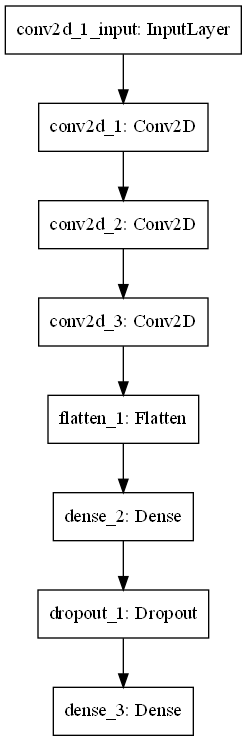

In [24]:
tf.keras.utils.plot_model(model, to_file='model_has_pnemonia.png')